In [2]:
from IPython.core.display import HTML
HTML("""
<style>

div.cell { /* Tunes the space between cells */
margin-top:1em;
margin-bottom:1em;
}

div.text_cell_render h1 { /* Main titles bigger, centered */
font-size: 2.2em;
line-height:1.4em;
text-align:center;
}

div.text_cell_render h2 { /*  Parts names nearer from text */
text-align:center;
margin-bottom: 0.4em;
}


div.text_cell_render { /* Customize text cells */
font-family: 'Times New Roman';
font-size:1em;
line-height:1.4em;
padding-left:3em;
padding-right:3em;
}
</style>
""")

# Writeup



Problem Statement:
<br>
The question this research attempts to answer is if there is a strong connection between the words used in a Udemy course headline and the price of the course. This could help those listing courses on Udemy to write headlines, and further, pick specific topics, that best fit in with the price bracket they are aiming to sell their course in. 
<br> Based on the guidelines put out by Udemy, the lowest an instructor can price a course is 19.99USD, and the highest is 199.99USD. Courses can also be listed as free, and are only allowed to switch from paid to free (or vice versa) once. Courses are often put on promotional discounts, influenced by market factors. The fact that courses are not always in the same price bracket still allows for using the results of this research to be valid at the point of API call. 
<br><br>
Data:<br>
The data comes from the Udemy courses API. It includes 5000 (or the max) records each from 5 course categories. The course categories are Design, Marketing, Development, Music and Lifestyle. The point of interests are the course headline, course category, and course price. The category is not included in the API result, so it is appended seperately, based on the category specified in the API call. 
In total the dataset includes 23912 rows and 4 columns: id, price, headline and category. 
<br><br>
Hypothesis:<br>
I predict that there will be certain words that correlate to higher prices in courses. These words will likely correspond to hot topics at the time of the API call. There might be futher research to be done to see if these words also see a recent spike on google trends. 
<br><br>
Methodology:<br>
For this research, the course prices are segmented into 2 categories, high and low. Low courses are priced between 0-199.9USD and high courses are priced between 100USD and 200USD.
<br>
For the Naive Bayes modelling, the course headlines are processed, cleaned of stopwords, and tokenized. Naive bayes classification is done on the data as a whole, and on each category individually. Then a logisitic regression is attempted.
<br>
<br>
Results:
<br>
(these results reflect the state at writing, however, running the models with the data from different api calls will give different results)
<br>
The models do not preform well, none of them surpassing 11% above the baseline, either on the data as a whole or on individual categories. 

The highest preforming model is Naive Bayes on the Development category. The baseline accuracy would be 53.1%, the accuracy of this model is 64.00%, which is 10.9% higher than baseline.
The second highest preforming model is LogisticRegression on the Development category, at 9.2% higher than baseline.

The lowest preforming model is the Multinomial Naive Bayes model for the lifestyle category. The baseline accuracy would be 78.3%, and the accuracy of the model is 70.80%, -7.5% lower than baseline. 

There seems to be a correlation between higher baselines (more unevenly segmented data) and worse preforming models. This should be looked into more. 

For more details, see the last section of this notebook.

<br>
<br>
Conclusions:<br>
There is some relation between the words in a course headline and the price bracket of that headline, however, it cannot be said to be a highly predictive variable, based on the results of this notebook. It is more predictive for some categories over others.

<br>
<br>
Next steps:<br>
Refine price bracketing to lower skew towards either 1 or 0.
<br>Figure out how to get free courses included in API call (they were as of May 29 2020, and made the division between 1 and 0 almost 50/50 when segmenting the data at ((max/2) -.01)). 
<br>
Refine model parameters
<br>
Add more categories
<br>
Look into running nonbinary models?


# Imports 

In [3]:

import json
import requests
import curl

from os import walk
from os.path import join
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from collections import Counter
from wordcloud import WordCloud
from bs4 import BeautifulSoup

from PIL import Image
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score

%matplotlib inline


In [4]:
sns.set(style="white", palette="muted", color_codes=True)


In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
import config
username= config.username
password= config.password


# Get Data

In [ ]:
import requests


# max_records is there so you can get back partial result sets, if you want. Useful for testing.
def get_all_course_data(max_records, category): 
    page_number = 1
    page_size = 100
    category=category
    more_records_exist = True
    all_courses = []

    while more_records_exist:
        api_response = get_courses(page_number, page_size, category)
        results = process_response(api_response)

        # add the new results to our aggregate set
        all_courses += results
    
        # if we get back fewer records than we asked for, we know we reached the end.
        # terminate the loop if we're at the end, or have hit our max.
        if len(results) < page_size or (max_records and len(all_courses) >= max_records):
            more_records_exist = False
        else:
            page_number += 1
            

    return all_courses

def get_courses(page_number, page_size, category): 
    courses_url = "https://www.udemy.com/api-2.0/courses/"

    query_params = {
        "page_size": page_size, 
        "page": page_number ,
        "category":category
    }

    credentials = (username, password)

    return requests.get(url=courses_url, auth=credentials, params=query_params).json()

def process_response(api_response):
    # api_response is a dictionary object which is a representation of the json structure.  
    courses = []

    # The json structure places all of the courses inside the results array
    for course in api_response['results']:
        # we add to the courses list tuples containing id, price, and headline.
        courses.append((course['id'], course['price'], course['headline']))
    return courses

def dataframing(result, category):
    df = pd.DataFrame.from_records(result, columns=['id', 'price', 'headline'])
    df['category']=category
    return df

In [ ]:
%%time

categories=['Design','Marketing','Development','Music','Lifestyle']

df=pd.DataFrame(columns=['id', 'price', 'headline','category'])
for i in range(len(categories)):
    n = get_all_course_data(max_records=5000, category=categories[i])
    n = dataframing(n, category=categories[i])
    df = df.append([n])

    

In [ ]:
df.reset_index(inplace=True)


In [ ]:
df.head()
df.drop(['index'],axis=1, inplace=True)
#df.drop(['level_0'],axis=1, inplace=True)


In [ ]:
df.head()

In [ ]:
df.to_csv('data/data_api.csv')
#df.to_csv('data/data_n.csv')


# Clean Data 

### A description  of the dataset


In [8]:
data = pd.read_csv('data/data_api.csv')

In [9]:
data

,Unnamed: 0,id,price,headline,category
0,0,874012,$149.99,Learn the #1 most important building block of ...,Design
1,1,1259404,$194.99,Learn How to Draw People and Character Designs...,Design
2,2,438522,$194.99,Use Blender to create beautiful 3D models for ...,Design
3,3,1197206,$199.99,Master Adobe Illustrator CC with this in-depth...,Design
4,4,1065056,$194.99,"Understand your audience, envision a creative ...",Design
...,...,...,...,...,...
23907,23907,3020956,Free,Scopriremo in questo corso come realizzare dei...,Lifestyle
23908,23908,3102206,Free,"Dicas para você Mulher, Mãe, Menina,Idosa, Gue...",Lifestyle
23909,23909,3023542,Free,Impareremo come realizzare una fantastica pizz...,Lifestyle
23910,23910,1722948,Free,Курс по созданию радостного настроения для све...,Lifestyle


In [10]:
#dropping excess column created with conversion to csv
data.drop([ 'Unnamed: 0'], axis=1, inplace=True)

### data types

In [11]:
data.dtypes

id           int64
price       object
headline    object
category    object
dtype: object

In [12]:
##converting nans to 0
data.fillna(0, inplace=True)

In [13]:
data.category = data.category.astype(str)
data.headline = data.headline.astype(str)
data.id = data.id.astype(int)

In [14]:
##cleaning price data
data.price.replace({'Free': 0}, inplace=True)
data['price'] = data['price'].str.replace('$', '')
data.price = data.price.astype(float)


In [15]:
##no free courses are being included in this api call
data['price'].min()


19.99

In [16]:
data.head()

,id,price,headline,category
0,874012,149.99,Learn the #1 most important building block of ...,Design
1,1259404,194.99,Learn How to Draw People and Character Designs...,Design
2,438522,194.99,Use Blender to create beautiful 3D models for ...,Design
3,1197206,199.99,Master Adobe Illustrator CC with this in-depth...,Design
4,1065056,194.99,"Understand your audience, envision a creative ...",Design


#### columns in the dataset

In [17]:
data.columns

Index(['id', 'price', 'headline', 'category'], dtype='object')

#### categories in the dataset

In [18]:
data.category.unique()

array(['Design', 'Marketing', 'Development', 'Music', 'Lifestyle'],
      dtype=object)

## Exploratory Graphs

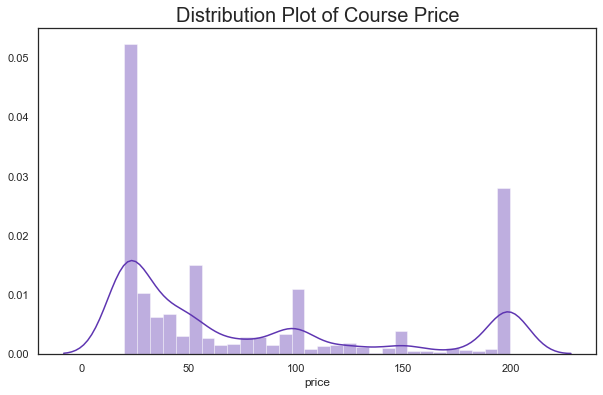

In [19]:

plt.figure(figsize= (10,6))
plt.title('Distribution Plot of Course Price', size=20)

sns.distplot(data['price'], bins=30, color='#5e35b1')
plt.show()

In [20]:
data['price'].describe()

count    22936.000000
mean        79.065253
std         66.244731
min         19.990000
25%         19.990000
50%         49.990000
75%        119.990000
max        199.990000
Name: price, dtype: float64

In [21]:
data['category'].value_counts()
#less than 5000 courses available for certian categories

Development    5000
Marketing      5000
Design         5000
Lifestyle      4876
Music          4036
Name: category, dtype: int64

### course prices are not evenly distributed, spiking at the min and max

## Boxplots

CPU times: user 84.4 ms, sys: 3.62 ms, total: 88 ms
Wall time: 90.7 ms


Text(0.5, 1.0, 'Box Plots of Price Distribution by Subject')

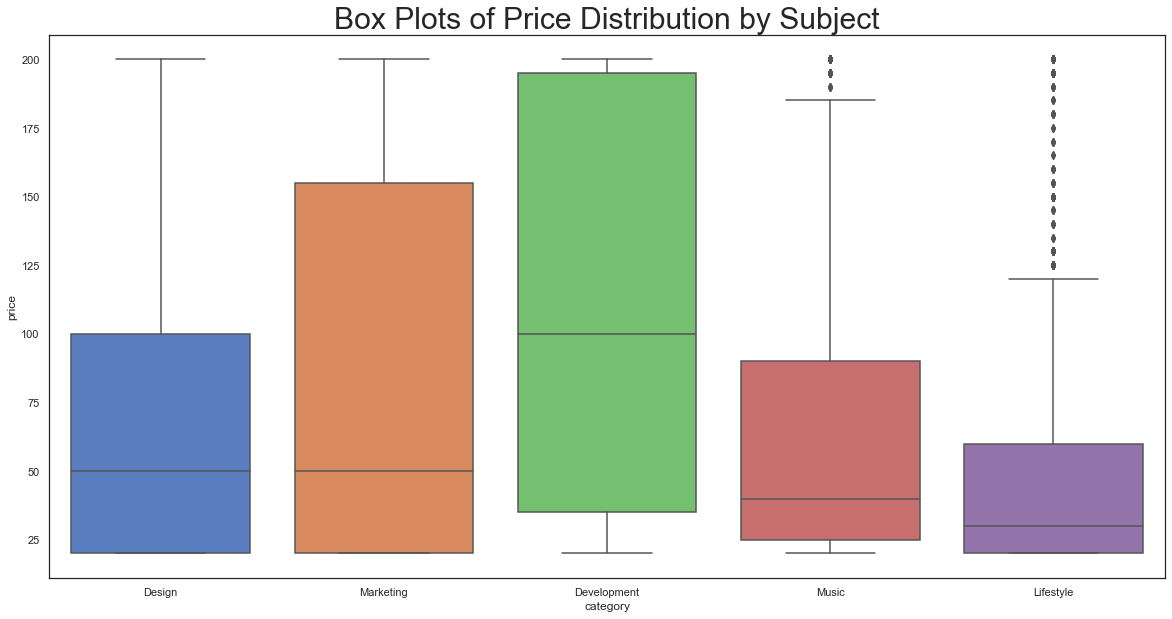

In [22]:
%%time

plt.figure(figsize=(20,10))
ax = sns.boxplot(x="category", y="price", data=data)
ax.set_title('Box Plots of Price Distribution by Subject', size=30)
#ax = sns.swarmplot(x="category", y="price", data=data, color='black', alpha=.4)

### from these boxplots we can see that some subjects tend to be more pricier than others. Development skews highest while lifestyle skews lowest. 

CPU times: user 29.7 ms, sys: 2.33 ms, total: 32 ms
Wall time: 33.9 ms


Text(0.5, 1.0, 'Box Plot of Price Distribution for all subjects')

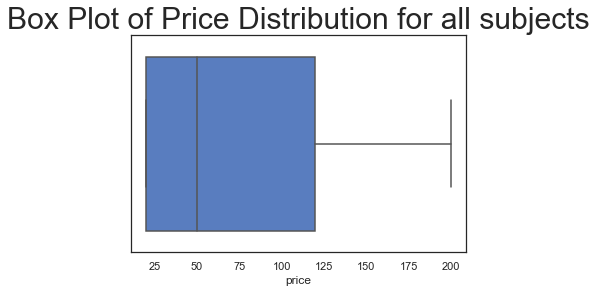

In [23]:
%%time

ax = sns.boxplot(data.price)
ax.set_title('Box Plot of Price Distribution for all subjects', size=30)
#ax = sns.swarmplot(data.price, color='black', alpha=.4)

# Segement data

### sections for division into 2 categories split the price data evenly in half between min and max, if the data includes free courses at the time of API call. Otherwise, segements data between max and 0.

In [24]:
data.price.describe()

count    22936.000000
mean        79.065253
std         66.244731
min         19.990000
25%         19.990000
50%         49.990000
75%        119.990000
max        199.990000
Name: price, dtype: float64

In [25]:
data.price.max()/2-1

98.995

In [26]:
data['price_bracket_2']=0
for i in range(0, len(data)):
    if (data.price[i] <= ((data.price.max()/2)-.01)):
        data['price_bracket_2'][i]=0
    else:
        data['price_bracket_2'][i]=1

In [27]:
data['price_bracket_2'].value_counts()

0    15296
1     8616
Name: price_bracket_2, dtype: int64

## visualize data segmentation

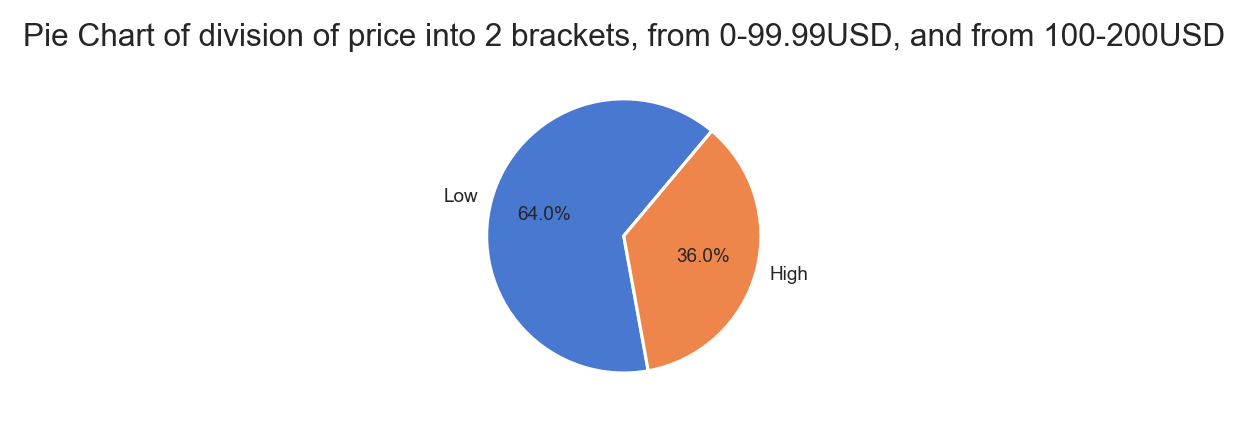

In [28]:
l = len(data[data.price_bracket_2==0])
h = len(data[data.price_bracket_2==1])

category_names = ['Low', 'High']
sizes = [l, h]
plt.figure(figsize= (2,2), dpi = 227)
plt.pie(sizes, labels=category_names, 
        textprops={'fontsize' :6} , startangle=50,
       autopct= '%1.1f%%')
plt.title('Pie Chart of division of price into 2 brackets, from 0-99.99USD, and from 100-200USD', size=10)

plt.show()

In [29]:
data.describe()

,id,price,price_bracket_2
count,2.391200e+04,22936.000000,23912.000000
mean,1.563808e+06,79.065253,0.360321
std,8.515731e+05,66.244731,0.480104
min,4.715000e+03,19.990000,0.000000
25%,8.540470e+05,19.990000,0.000000
50%,1.544801e+06,49.990000,0.000000
75%,2.309464e+06,119.990000,1.000000
max,3.168960e+06,199.990000,1.000000


#### save as csv

In [30]:
data.to_csv('data/cleaned_data.csv')

# NLP Preprocessing

In [31]:
data = pd.read_csv('data/cleaned_data.csv')

### define stopwords

In [32]:
data.category.unique()

array(['Design', 'Marketing', 'Development', 'Music', 'Lifestyle'],
      dtype=object)

In [33]:
my_stopwords = ['a','the','and','of',
                'for','by','an', 'to',
                'in', 'learn', 'how', 'from', 'with', 
                'your', 'you', 'course', 'build', 'use', 'using',
                'on', 'this','that', 'get', 'or','is', 'create', 
                'guide', 'step','make','master','more','will','own',
               'skills', 'design', 'marketing', 'development', 'music', 'lifestyle',
               'it', 'de', 'all']

### these stopwords are chosen based on words that are seen to be common in all categories, but say little about the content of the course. It also includes the names of the categories.

### make function for cleaning and tokenizing

In [34]:
def clean_message(message,
                 stop_words=set(my_stopwords)):
    
    words = word_tokenize(message.lower())
    
    filtered_words =[]
    
    for word in words:
        if word not in stop_words and word.isalpha():
            filtered_words.append((word))
        
    return filtered_words

# NLP Exploration

### create seperate dataframes for high priced and low priced courses

In [35]:
data_h = data[data.price_bracket_2 == 1]
data_h.reset_index(inplace=True)
data_l = data[data.price_bracket_2 == 0]
data_l.reset_index(inplace=True)


### create function to output unique words value counts, and the word list as a string

In [36]:
def unique_words(df):
    '''
    Parameters:
    df: dataframe with 'headline' column including course headlines to be processed

    Returns:
    as_string: words of headline column as string
    unique_words: a series of unique words in the df and their value counts
    '''
    df['words'] = 0
    total_words =[]
    for i in range(len(df['words'])):
        filtered_words = clean_message(df['headline'][i])
        df['words'][i] = filtered_words
        total_words.append(filtered_words)
    flat_list = [item for sublist in total_words for item in sublist]
    word_list = [''.join(word) for word in flat_list]
    as_string = ' '.join(word_list)
    unique_words= pd.Series(flat_list).value_counts()
    return as_string, unique_words

   


In [37]:

as_string_h, unique_words_h = unique_words(data_h)
as_string_l, unique_words_l = unique_words(data_l)
as_string, unique_words = unique_words(data)


In [38]:
type (unique_words_l)

pandas.core.series.Series

### create function to print information on unique words for high priced, low priced, and all courses

In [39]:
def print_unique(uw, subset):
    '''
    
    Parameters:
    uw: series of unique words, produced in unique_words function
    subset: description of the price bracket of uw

    Returns:
    None; outputs descriptive print statements'''
    
    print ('nr of unique words in {}:'.format(subset))
    print (uw.shape[0])
    print ('Top 15 unique words in {}:'.format(subset))
    print (uw.head(15))
    print ('________________')
    

In [40]:
print_unique(unique_words_h, 'courses priced over 100$')
print_unique(unique_words_l, 'courses priced $99.99 or less')
print_unique(unique_words, 'all courses')

nr of unique words in courses priced over 100$:
9934
Top 15 unique words in courses priced over 100$:
business       499
complete       476
web            460
python         432
learning       383
scratch        374
facebook       357
data           343
seo            322
become         312
beginners      309
advanced       306
programming    305
start          292
website        291
dtype: int64
________________
nr of unique words in courses priced $99.99 or less:
16242
Top 15 unique words in courses priced $99.99 or less:
business        660
easy            640
techniques      518
beginners       440
complete        432
web             428
website         417
video           409
start           390
play            382
can             379
para            377
basics          375
professional    375
e               372
dtype: int64
________________
nr of unique words in all courses:
19833
Top 15 unique words in all courses:
business        1159
complete         908
web              888


# WordClouds

In [41]:
def word_cloud(image, data, color_map, title):
    '''
    Parameters:
    image: image mask for worldcloud
    data: the string input of words to be included in wordcloud
    color_map: colormap for wordcloud
    title: title for worldcloud

    Returns:
    None; plots wordcloud
    
    '''
    
    icon = Image.open(image)
    image_mask= Image.new(mode='RGB', size=icon.size, color=(255,255,255))
    image_mask.paste(icon, box=icon)
    rgb_array=np.array(image_mask) #converts image object to array

    word_cloud = WordCloud(mask = rgb_array, background_color='white',
                          max_words=400, colormap=color_map)
    word_cloud.generate(data)
    plt.figure(figsize=[16,8])
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, size=20)
    plt.show()
    

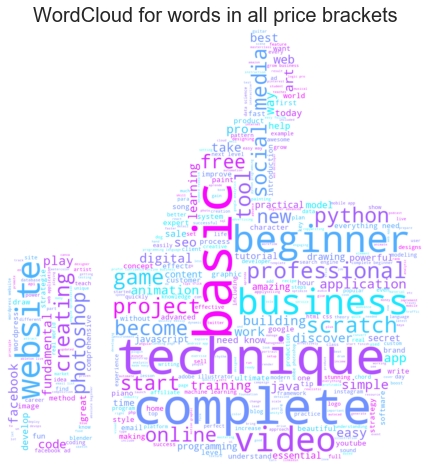

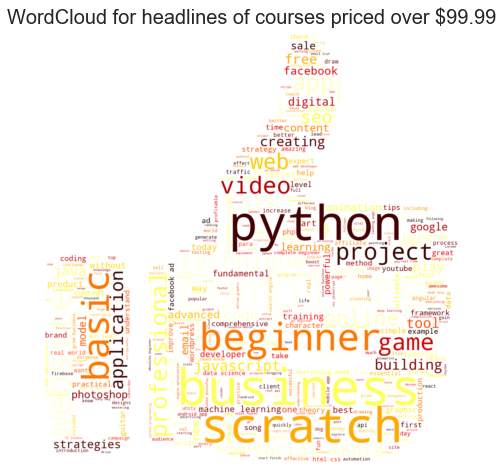

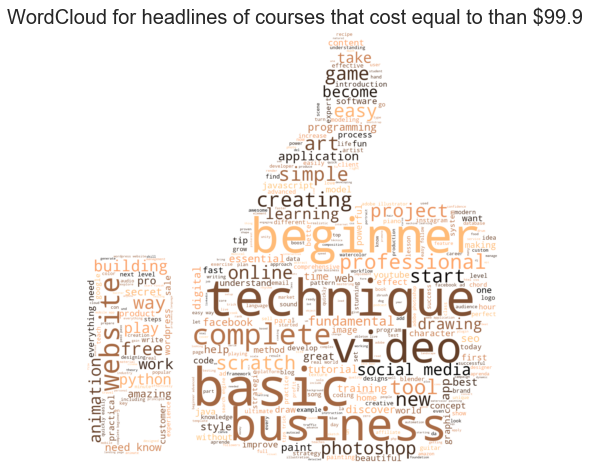

In [42]:
word_cloud('data/thumbs-up.png', as_string, 'cool', 'WordCloud for words in all price brackets' )
word_cloud('data/thumbs-up.png', as_string_h, 'hot', 'WordCloud for headlines of courses priced over $99.99' )
word_cloud('data/thumbs-up.png', as_string_l, 'copper', 'WordCloud for headlines of courses that cost equal to than $99.9' )


# Generate and Evaluate Predictive Models

### Creating function 

In [43]:
def pred_mod(data, prices, classifier, classifier_name):
    '''Parameters:
    data: dataframe of interest
    prices: price data, segmented into high/low price binary
    classifier: model to be run
    classifier_name: name of model

    Returns:
    None; prints information on model results
    '''
    
    vectorizer =  CountVectorizer(stop_words=set(my_stopwords))
    all_features = vectorizer.fit_transform(data.headline)

    X_train, X_test, y_train, y_test = train_test_split(all_features,
                                                       prices,
                                                       test_size=0.2,
                                                       random_state=100)

    classifier = classifier()
    classifier.fit(X_train,y_train)
    

    y_hat = (classifier.predict(X_test))
    nr_corr = (y_test == y_hat).sum()
    preds = classifier.predict(X_test)

    number_wrong = sum(abs(y_hat - y_test))
    fraction_wrong = (number_wrong/(len(y_test)))
    price_brackets = len(prices.unique())
    accuracy = (1- fraction_wrong)
    # calculate null accuracy in a single line of code
    # only for binary classification problems coded as 0/1
    baseline = max(y_test.mean(), 1 - y_test.mean())
    higher = accuracy-baseline


    print (' ')
    print ("this {} model includes these course categories {}".format(classifier_name, data.category.unique()))
    print (' ')
    print ("the baseline accuracy would be {:.1%}".format(baseline))
    print ("the accuracy of this {} model is {:.2%}".format(classifier_name, accuracy))
    print ("the accuracy is {:.1%} higher than baseline".format(higher))
    print (' ')

    print ("the percent of predictions the model gets wrong is {:.2%}".format(fraction_wrong))
    print ("the recall is {:.2%}".format(recall_score(y_test, preds, average='weighted')))
    print ("the precision is {:.2%}".format(precision_score(y_test, preds, average='weighted')))



### setting categories and models

In [44]:
categories=['Design','Marketing','Development','Music','Lifestyle']

#can add models
models=[LogisticRegression, MultinomialNB]
model_names=['LogisticRegression', 'Multinomial Naive Bayes']


### running models for entire dataframe

In [45]:

for j in range(len(models)):
    pred_mod(data, data.price_bracket_2, models[j], model_names[j])
    print ('_____________')


 
this LogisticRegression model includes these course categories ['Design' 'Marketing' 'Development' 'Music' 'Lifestyle']
 
the baseline accuracy would be 63.9%
the accuracy of this LogisticRegression model is 68.14%
the accuracy is 4.2% higher than baseline
 
the percent of predictions the model gets wrong is 31.86%
the recall is 68.14%
the precision is 66.83%
_____________
 
this Multinomial Naive Bayes model includes these course categories ['Design' 'Marketing' 'Development' 'Music' 'Lifestyle']
 
the baseline accuracy would be 63.9%
the accuracy of this Multinomial Naive Bayes model is 66.13%
the accuracy is 2.2% higher than baseline
 
the percent of predictions the model gets wrong is 33.87%
the recall is 66.13%
the precision is 66.83%
_____________


### running models segmented by category

In [46]:
for j in range(len(models)):
    for i in categories:
        data_n = 'data{}'.format(i)
        data_n=data[data['category']==i]
        pred_mod(data_n, data_n.price_bracket_2, models[j], model_names[j])
        print ('_____________')

    

 
this LogisticRegression model includes these course categories ['Design']
 
the baseline accuracy would be 70.3%
the accuracy of this LogisticRegression model is 71.80%
the accuracy is 1.5% higher than baseline
 
the percent of predictions the model gets wrong is 28.20%
the recall is 71.80%
the precision is 69.21%
_____________
 
this LogisticRegression model includes these course categories ['Marketing']
 
the baseline accuracy would be 58.8%
the accuracy of this LogisticRegression model is 61.00%
the accuracy is 2.2% higher than baseline
 
the percent of predictions the model gets wrong is 39.00%
the recall is 61.00%
the precision is 60.29%
_____________
 
this LogisticRegression model includes these course categories ['Development']
 
the baseline accuracy would be 53.1%
the accuracy of this LogisticRegression model is 62.10%
the accuracy is 9.0% higher than baseline
 
the percent of predictions the model gets wrong is 37.90%
the recall is 62.10%
the precision is 62.10%
__________